## Normalization of data

### Content

1. Load modules
2. Import data
5. Normalization using IS vals of targeted data (manual check for control pools)

### 1. Load modules

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from datetime import date
import matplotlib.patches as mpatches

In [2]:
# define date for saving figures
today = date.today().strftime("%Y-%m-%d") # for saving files
# set number of columns to show when display is called
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

### 2. Import data

In [3]:
# Set wd
os.chdir('/Users/clanc/OneDrive/Masterarbeit/analysis')

In [4]:
# Load info tables
screen_info = pd.read_csv('curated_input/screen_info.txt', \
                                   sep = ';', header = 0, index_col = 0)

strain_info = pd.read_csv('curated_input/strain_info.txt', \
                                   sep = ';', header = 0, index_col = 0)


In [5]:
# Load ms data
targeted_ms_paths = glob.glob(\
    'intermed_results/01_noBadInjections/data/targeted_per_strain/*_input_targeted_*')
targeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                      for file in targeted_ms_paths]

fix_merge_table_paths = glob.glob(\
    'intermed_results/03_fix_missMerge/data/untargeted_tables/*fix_merge_flag3_4*')
untargeted_perS_list = [pd.read_csv(file, header = 0, index_col = 0, sep = ';')\
                        for file in fix_merge_table_paths]


del(targeted_ms_paths, fix_merge_table_paths)


In [6]:
# strain index vector

strain_list = [table.columns[0].split('-')[3] for table in untargeted_perS_list]

In [7]:
# IS references

IS_list_full_name = ['IS_SPARTEINE', 'IS_EMETINE','IS_CAFFEINE',
                     'IS_YOHIMBINE', 'IS_SULFAMETHOXAZOLE', 'IS_EYTHROMYCINE',
                     'IS_MIFEPRISTONE', 'IS_IPRIFLAVONE']

IS_mass_refs =  [
        234.20960, #sparteine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:28827
        480.29881, #emetine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:4781
        194.08038, #caffeine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:27732
        354.19434, #yohimbine: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:10093
        253.05211, #sulfamethoxazole: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:9332
        733.46124, #erythromycin A (questionalble): https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:42355
        429.26678, #mifepristone: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:50692
        280.10994  #ipriflavone: https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:31719
        ]

IS_dict = dict(zip(IS_list_full_name, IS_mass_refs))

IS_total_names = ['sparteine', 'emetine', 'caffeine', 'yohimbine','sulfamethoxazole', \
                  'erythromycin A', 'mifepristone', 'ipriflavone']

Get intensity values

In [8]:
IS_list =  list(IS_dict.keys())

IS_ints =  []

for IS_name in IS_list:
    
    IS_vals = []
    
    for cur_table in targeted_perS_list:
        new_vals = cur_table.loc[cur_table.index.str.startswith(IS_name),\
                                 cur_table.columns.str.endswith('Area')].\
                                 values.tolist()[0]
        IS_vals.extend(new_vals)
        
    IS_ints.append(IS_vals)

In [9]:
# get median of internal standards (targeted) and save in dict:
#------------------------------------------------------------------
IS_medians = [np.nanmedian(vals) for vals in IS_ints]
IS_med_dict = dict(zip(IS_list_full_name, IS_medians))


In [10]:
# define internal standards to be used
IS_use_list = ['IS_CAFFEINE',
               'IS_IPRIFLAVONE',
               'IS_MIFEPRISTONE',
               'IS_SULFAMETHOXAZOLE',
               'IS_YOHIMBINE']

In [11]:
tar_IS_vals_perS = []

for cur_table in targeted_perS_list:
    new_vals = cur_table.loc[cur_table.index.isin(IS_use_list),\
                                 cur_table.columns.str.endswith('Area')]
    tar_IS_vals_perS.append(new_vals)


In [12]:
# get median of internal standards (untargeted) and save in dict:
#------------------------------------------------------------------

# Get IS values in control pools

untar_IS_vals_perS = []
untar_IS_vals_perS_list = []


for s_table in untargeted_perS_list:
    #s_table = untargeted_perS_list[76]
    IS_untar_vals = pd.DataFrame(columns = s_table.columns)
    
    all_is_rows = []
    
    for i in IS_use_list:
        
        #i = IS_use_list[4]
        is_mass = IS_dict[i]
        is_rows = s_table.loc[(s_table['Mass'] > (is_mass-0.0015)) & \
                                  (s_table['Mass'] < (is_mass+0.0015))]

        
        all_is_rows.append(is_rows)
        
        # in case more than one row is found use the one with less missing values
            # (idea: IS should be detected in every pool)
        if is_rows.shape[0] > 1:
            nan_counts = is_rows.isnull().sum(axis=1)
            is_use_row = is_rows.loc[[nan_counts.idxmin()],]
        else:
            if is_rows.shape[0] == 0:
                is_use_row = is_rows.append(pd.DataFrame([np.float('nan') for n in\
                            range(is_rows.shape[1])], columns=is_rows.columns))
            else:
                is_use_row = is_rows
        
        
        IS_untar_vals = IS_untar_vals.append(is_use_row)
    
    untar_IS_vals_perS_list.append(all_is_rows)
    
    IS_untar_vals.index = IS_use_list
    
    untar_IS_vals_perS.append(IS_untar_vals)



In [21]:
untar_IS_vals_perS[0]

MZ002H-Pool01-P001B1-S005-T00(raw)  \
IS_CAFFEINE                                   1096145.0   
IS_IPRIFLAVONE                               13100000.0   
IS_MIFEPRISTONE                                     NaN   
IS_SULFAMETHOXAZOLE                           3095748.0   
IS_YOHIMBINE                                  9772227.0   

                     MZ002H-Pool01-P001B1-S005-T12(raw)  \
IS_CAFFEINE                                    898560.0   
IS_IPRIFLAVONE                                7469010.0   
IS_MIFEPRISTONE                               2676125.0   
IS_SULFAMETHOXAZOLE                           3337213.0   
IS_YOHIMBINE                                  9522241.0   

                     MZ002H-Pool02-P001B1-S005-T00(raw)  \
IS_CAFFEINE                                   1047325.0   
IS_IPRIFLAVONE                                9495405.0   
IS_MIFEPRISTONE                                249589.0   
IS_SULFAMETHOXAZOLE                           3097501.0   
IS_YOHIMBINE                                  8506711.0   

                     MZ002H-Pool02-P001B1-S005-T12(raw)  \
IS_CAFFEINE                                    925119.0   
IS_IPRIFLAVONE                                6851266.0   
IS_MIFEPRISTONE                               3159864.0   
IS_SULFAMETHOXAZOLE                           3064398.0   
IS_YOHIMBINE                                  8431050.0   

                     MZ002H-Pool03-P001B1-S005-T00(raw)  \
IS_CAFFEINE                                   1047078.0   
IS_IPRIFLAVONE                                9709529.0   
IS_MIFEPRISTONE                               3120041.0   
IS_SULFAMETHOXAZOLE                           2344457.0   
IS_YOHIMBINE                                 10200000.0   

                     MZ002H-Pool03-P001B1-S005-T12(raw)  \
IS_CAFFEINE                                   1064421.0   
IS_IPRIFLAVONE                                7786372.0   
IS_MIFEPRISTONE                               3774174.0   
IS_SULFAMETHOXAZOLE                           3047910.0   
IS_YOHIMBINE                                 10800000.0   

                     MZ002H-Pool04-P001B1-S005-T00(raw)  \
IS_CAFFEINE                                    958409.0   
IS_IPRIFLAVONE                                7911069.0   
IS_MIFEPRISTONE                               2224497.0   
IS_SULFAMETHOXAZOLE                           2243567.0   
IS_YOHIMBINE                                  8758592.0   

                     MZ002H-Pool04-P001B1-S005-T12(raw)  \
IS_CAFFEINE                                   1178800.0   
IS_IPRIFLAVONE                                6400140.0   
IS_MIFEPRISTONE                               3140773.0   
IS_SULFAMETHOXAZOLE                           3300271.0   
IS_YOHIMBINE                                 10400000.0   

                     MZ002H-Pool05-P001B1-S005-T00(raw)  \
IS_CAFFEINE                                    940431.0   
IS_IPRIFLAVONE                                8127070.0   
IS_MIFEPRISTONE                               2840398.0   
IS_SULFAMETHOXAZOLE                           2869790.0   
IS_YOHIMBINE                                        NaN   

                     MZ002H-Pool05-P001B1-S005-T12(raw)  \
IS_CAFFEINE                                   1009917.0   
IS_IPRIFLAVONE                                6747011.0   
IS_MIFEPRISTONE                               3521552.0   
IS_SULFAMETHOXAZOLE                           3532957.0   
IS_YOHIMBINE                                 10700000.0   

                     MZ002H-Pool06-P001B1-S005-T00(raw)  \
IS_CAFFEINE                                    980507.0   
IS_IPRIFLAVONE                                7538135.0   
IS_MIFEPRISTONE                               2694163.0   
IS_SULFAMETHOXAZOLE                           2998684.0   
IS_YOHIMBINE                                        NaN   

                     MZ002H-Pool06-P001B1-S005-T12(raw)  \
IS_CAFFEINE                                   1113325.0  

In [17]:
untar_IS_vals_perS_list[55][1]

MZ002H-Pool01-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                            224745.0   
280.1109@4.789355                            6096093.0   

                    MZ002H-Pool01-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                            266168.0   
280.1109@4.789355                            9536430.0   

                    MZ002H-Pool02-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                            254222.0   
280.1109@4.789355                            7506650.0   

                    MZ002H-Pool02-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                            271595.0   
280.1109@4.789355                           11100000.0   

                    MZ002H-Pool03-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            5263267.0   

                    MZ002H-Pool03-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            9296805.0   

                    MZ002H-Pool04-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            7379829.0   

                    MZ002H-Pool04-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                            248613.0   
280.1109@4.789355                            9395932.0   

                    MZ002H-Pool05-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                            224393.0   
280.1109@4.789355                            5567893.0   

                    MZ002H-Pool05-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                            251800.0   
280.1109@4.789355                            7801963.0   

                    MZ002H-Pool06-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                            221453.0   
280.1109@4.789355                            6070942.0   

                    MZ002H-Pool06-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                            262869.0   
280.1109@4.789355                            8786107.0   

                    MZ002H-Pool07-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            7216559.0   

                    MZ002H-Pool07-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            7174345.0   

                    MZ002H-Pool08-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                            235167.0   
280.1109@4.789355                            6641015.0   

                    MZ002H-Pool08-P006A4-S064-T12(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            8375705.0   

                    MZ002H-Pool09-P006A4-S064-T00(raw)  \
Compound                                                 
280.1085@1.1531851                                 NaN   
280.1109@4.789355                            8150884.0   

                    MZ002H-Pool09-P006A4-S064-T12(raw)  \
C

In [32]:
tar_IS_vals_perS[55]

MZ002H-Pool01-P006A4-S064-T00-Area  \
IS_CAFFEINE                                    653013.0   
IS_IPRIFLAVONE                                4615122.0   
IS_MIFEPRISTONE                               3127933.0   
IS_SULFAMETHOXAZOLE                           1455059.0   
IS_YOHIMBINE                                  5588739.0   

                     MZ002H-Pool01-P006A4-S064-T12-Area  \
IS_CAFFEINE                                    658171.0   
IS_IPRIFLAVONE                                7265026.0   
IS_MIFEPRISTONE                               4627571.0   
IS_SULFAMETHOXAZOLE                           1455510.0   
IS_YOHIMBINE                                  5549437.0   

                     MZ002H-Pool02-P006A4-S064-T00-Area  \
IS_CAFFEINE                                    633248.0   
IS_IPRIFLAVONE                                5680593.0   
IS_MIFEPRISTONE                               3788476.0   
IS_SULFAMETHOXAZOLE                           1384005.0   
IS_YOHIMBINE                                  5310337.0   

                     MZ002H-Pool02-P006A4-S064-T12-Area  \
IS_CAFFEINE                                    698160.0   
IS_IPRIFLAVONE                                8412726.0   
IS_MIFEPRISTONE                               5592624.0   
IS_SULFAMETHOXAZOLE                           1486397.0   
IS_YOHIMBINE                                  5693078.0   

                     MZ002H-Pool03-P006A4-S064-T00-Area  \
IS_CAFFEINE                                    679378.0   
IS_IPRIFLAVONE                                3958400.0   
IS_MIFEPRISTONE                               3516858.0   
IS_SULFAMETHOXAZOLE                           1156847.0   
IS_YOHIMBINE                                  6488215.0   

                     MZ002H-Pool03-P006A4-S064-T12-Area  \
IS_CAFFEINE                                    713421.0   
IS_IPRIFLAVONE                                7045736.0   
IS_MIFEPRISTONE                               5798757.0   
IS_SULFAMETHOXAZOLE                           1152954.0   
IS_YOHIMBINE                                  6637964.0   

                     MZ002H-Pool04-P006A4-S064-T00-Area  \
IS_CAFFEINE                                    643998.0   
IS_IPRIFLAVONE                                5529740.0   
IS_MIFEPRISTONE                               3939599.0   
IS_SULFAMETHOXAZOLE                           1046065.0   
IS_YOHIMBINE                                  5875409.0   

                     MZ002H-Pool04-P006A4-S064-T12-Area  \
IS_CAFFEINE                                    662699.0   
IS_IPRIFLAVONE                                7108710.0   
IS_MIFEPRISTONE                               4755459.0   
IS_SULFAMETHOXAZOLE                           1096692.0   
IS_YOHIMBINE                                  5960112.0   

                     MZ002H-Pool05-P006A4-S064-T00-Area  \
IS_CAFFEINE                                    685454.0   
IS_IPRIFLAVONE                                4218583.0   
IS_MIFEPRISTONE                               3514715.0   
IS_SULFAMETHOXAZOLE                           1464517.0   
IS_YOHIMBINE                                  5623742.0   

                     MZ002H-Pool05-P006A4-S064-T12-Area  \
IS_CAFFEINE                                    679752.0   
IS_IPRIFLAVONE                                5938259.0   
IS_MIFEPRISTONE                               4558513.0   
IS_SULFAMETHOXAZOLE                           1485791.0   
IS_YOHIMBINE                                  5794482.0   

                     MZ002H-Pool06-P006A4-S064-T00-Area  \
IS_CAFFEINE                                    584353.0   
IS_IPRIFLAVONE                                4578028.0   
IS_MIFEPRISTONE                               3495459.0   
IS_SULFAMETHOXAZOLE                           1319439.0   
IS_YOHIMBINE                                  5387592.0   

                     MZ002H-Pool06-P006A4-S064-T12-Area  \
IS_CAFFEINE                                    687931.0  

In [18]:
# Test match of IS values

for test_strain, table in enumerate(untar_IS_vals_perS):
    
    cols = []
    for m in range(int(42/2)):
        cols.extend(['red', 'blue']) 
    
    fig, axs = plt.subplots(ncols = 5, figsize = (18,6), sharey=True)
    
    for test_IS in range(5):
        
        axs[test_IS].scatter(tar_IS_vals_perS[test_strain].iloc[test_IS,:42], \
            untar_IS_vals_perS[test_strain].iloc[test_IS,:42],\
                             c = cols) 
    #plt.show()
    strain = untar_IS_vals_perS[test_strain].columns[0].split('-')[3]
    plt.suptitle('Untargeted vs targeted IS data - '+ strain)
    red_patch = mpatches.Patch(color='red', label='T00')
    blue_patch = mpatches.Patch(color='blue', label='T12')
    plt.legend(handles=[red_patch, blue_patch], loc ='lower right')
    plt.savefig('intermed_results/04_normalization/IS_comp_plots/'+\
            today+'_IS_comp_'+str(test_strain).zfill(2)+'.pdf',\
            bbox_inches='tight')
    
    plt.close('all')



In [19]:
test_strain

76

In [12]:
IS_ints_untar =  []

for IS_name in IS_use_list:
    
    IS_vals = []
    
    for cur_table in untar_IS_vals_perS:
        new_vals = cur_table.loc[[IS_name], cur_table.columns.str.endswith('(raw)')].\
                                 values.tolist()[0]
        IS_vals.extend(new_vals)
        
    IS_ints_untar.append(IS_vals)

NameError: name 'untar_IS_vals_perS' is not defined

In [14]:
# get median of internal standards (untargeted) and save in dict:
#------------------------------------------------------------------
IS_medians_untar = [np.nanmedian(vals) for vals in IS_ints_untar]
IS_med_untar_dict = dict(zip(IS_use_list, IS_medians_untar))

In [15]:
IS_med_untar_dict

{'IS_CAFFEINE': 964727.0,
 'IS_IPRIFLAVONE': 7716889.5,
 'IS_MIFEPRISTONE': 3659845.5,
 'IS_SULFAMETHOXAZOLE': 2619878.0,
 'IS_YOHIMBINE': 8821112.0}

In [43]:
IS_med_dict

{'IS_SPARTEINE': 2696377.0,
 'IS_EMETINE': 1466232.5,
 'IS_CAFFEINE': 900412.0,
 'IS_YOHIMBINE': 7272108.5,
 'IS_SULFAMETHOXAZOLE': 2165575.5,
 'IS_EYTHROMYCINE': 2369868.0,
 'IS_MIFEPRISTONE': 2861548.0,
 'IS_IPRIFLAVONE': 6102719.0}

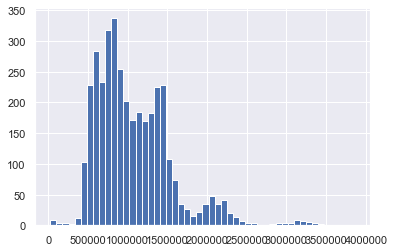

In [59]:
plt.hist(IS_ints_untar[0], bins = 50)
plt.show()

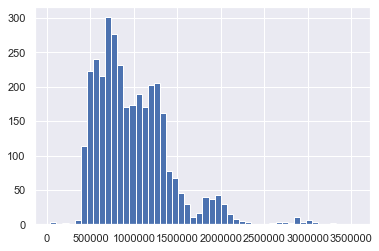

In [58]:
plt.hist(IS_ints[2], bins = 50)
plt.show()

### Normalize targeted data tables

In [13]:
targeted_perS_norm_list = []

alpha_perS_record = []

is_order_rec = []

for i in range(len(targeted_perS_list)):
    
    s_table = targeted_perS_list[i].copy()
    
    alpha_record = pd.DataFrame(columns = s_table.columns, index = ['alpha'])
    
    for col in s_table.columns:
        # col = s_table.columns[5]
        
        # get IS vals
        is_vals = s_table.loc[IS_use_list, col]
        
        # divide by median and sort
        is_vals_scaled = pd.Series([is_vals[is_name]/IS_med_dict[is_name] for \
                                    is_name in is_vals.keys()],\
                                    index = IS_use_list).sort_values()
        
        is_order_rec.append(is_vals_scaled)
        
        # get normalisation factor (mean of more stable ones)
        alpha = np.nanmean(is_vals_scaled.take([1,2,3]))
        
        alpha_record.loc['alpha', col] = alpha
        
        # devide column by this mean
        s_table.loc[:, col] = s_table.loc[:, col].copy() / alpha
        
    targeted_perS_norm_list.append(s_table)
    alpha_perS_record.append(alpha_record)

In [14]:
is_order_rec

[IS_MIFEPRISTONE        0.009726
 IS_YOHIMBINE           1.076811
 IS_CAFFEINE            1.100455
 IS_SULFAMETHOXAZOLE    1.173757
 IS_IPRIFLAVONE         1.699069
 dtype: float64,
 IS_MIFEPRISTONE        0.700079
 IS_CAFFEINE            0.904731
 IS_IPRIFLAVONE         0.971960
 IS_YOHIMBINE           1.050014
 IS_SULFAMETHOXAZOLE    1.247153
 dtype: float64,
 IS_MIFEPRISTONE        0.064036
 IS_YOHIMBINE           0.940400
 IS_CAFFEINE            1.054773
 IS_SULFAMETHOXAZOLE    1.166084
 IS_IPRIFLAVONE         1.227695
 dtype: float64,
 IS_MIFEPRISTONE        0.823647
 IS_IPRIFLAVONE         0.888518
 IS_CAFFEINE            0.928828
 IS_YOHIMBINE           0.934937
 IS_SULFAMETHOXAZOLE    1.146545
 dtype: float64,
 IS_MIFEPRISTONE        0.792638
 IS_SULFAMETHOXAZOLE    0.944794
 IS_CAFFEINE            1.055643
 IS_YOHIMBINE           1.126194
 IS_IPRIFLAVONE         1.259976
 dtype: float64,
 IS_MIFEPRISTONE        0.967290
 IS_IPRIFLAVONE         1.013115
 IS_CAFFEINE            

In [93]:
for i, table in enumerate(targeted_perS_norm_list):
    s_name = table.columns[0].split('-')[3]
    table.to_csv('intermed_results/04_normalization/data/targeted/'+\
                     str(i+1).zfill(2)+'_tar_norm_'+s_name+'.txt', sep = ';')
    

In [102]:
targeted_perS_list[0]

MZ002H-Pool01-P001B1-S005-T00-Area  \
ABACAVIR SULFATE                                         NaN   
ACEBUTOLOL HYDROCHLORIDE                                 NaN   
ACECAINIDE HYDROCHLORIDE                                 NaN   
ALFUZOSIN HYDROCHLORIDE                                  NaN   
ALMOTRIPTAN                                              NaN   
...                                                      ...   
WARFARIN                                          12717643.0   
ZALEPLON                                                 NaN   
ZIDOVUDINE [AZT]                                         NaN   
ZIPRASIDONE MESYLATE                                     NaN   
ZOLPIDEM                                                 NaN   

                          MZ002H-Pool01-P001B1-S005-T12-Area  \
ABACAVIR SULFATE                                         NaN   
ACEBUTOLOL HYDROCHLORIDE                                 NaN   
ACECAINIDE HYDROCHLORIDE                                 NaN   
ALFUZOSIN HYDROCHLORIDE                                  NaN   
ALMOTRIPTAN                                              NaN   
...                                                      ...   
WARFARIN                                          15629739.0   
ZALEPLON                                                 NaN   
ZIDOVUDINE [AZT]                                         NaN   
ZIPRASIDONE MESYLATE                                     NaN   
ZOLPIDEM                                                 NaN   

                          MZ002H-Pool02-P001B1-S005-T00-Area  \
ABACAVIR SULFATE                                         NaN   
ACEBUTOLOL HYDROCHLORIDE                           9577403.0   
ACECAINIDE HYDROCHLORIDE                                 NaN   
ALFUZOSIN HYDROCHLORIDE                                  NaN   
ALMOTRIPTAN                                              NaN   
...                                                      ...   
WARFARIN                                          12447393.0   
ZALEPLON                                                 NaN   
ZIDOVUDINE [AZT]                                         NaN   
ZIPRASIDONE MESYLATE                                     NaN   
ZOLPIDEM                                                 NaN   

                          MZ002H-Pool02-P001B1-S005-T12-Area  \
ABACAVIR SULFATE                                         NaN   
ACEBUTOLOL HYDROCHLORIDE                          10870384.0   
ACECAINIDE HYDROCHLORIDE                                 NaN   
ALFUZOSIN HYDROCHLORIDE                                  NaN   
ALMOTRIPTAN                                              NaN   
...                                                      ...   
WARFARIN                                          14780677.0   
ZALEPLON                                                 NaN   
ZIDOVUDINE [AZT]                                         NaN   
ZIPRASIDONE MESYLATE                                     NaN   
ZOLPIDEM                                                 NaN   

                          MZ002H-Pool03-P001B1-S005-T00-Area  \
ABACAVIR SULFATE                                         NaN   
ACEBUTOLOL HYDROCHLORIDE                                 NaN   
ACECAINIDE HYDROCHLORIDE                                 NaN   
ALFUZOSIN HYDROCHLORIDE                            9363242.0   
ALMOTRIPTAN                                              NaN   
...                                                      ...   
WARFARIN                                                 NaN   
ZALEPLON                                                 NaN   
ZIDOVUDINE [AZT]                                      9582.0   
ZIPRASIDONE MESYLATE                                325599.0   
ZOLPIDEM                                                 NaN   

                          MZ002H-Pool03-P001B1-S005-T12-Area  \
ABACAVIR SULFATE                                         NaN   
ACEBUTOLOL HYDROCHLORIDE                             

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the c

IndexError: list index out of range

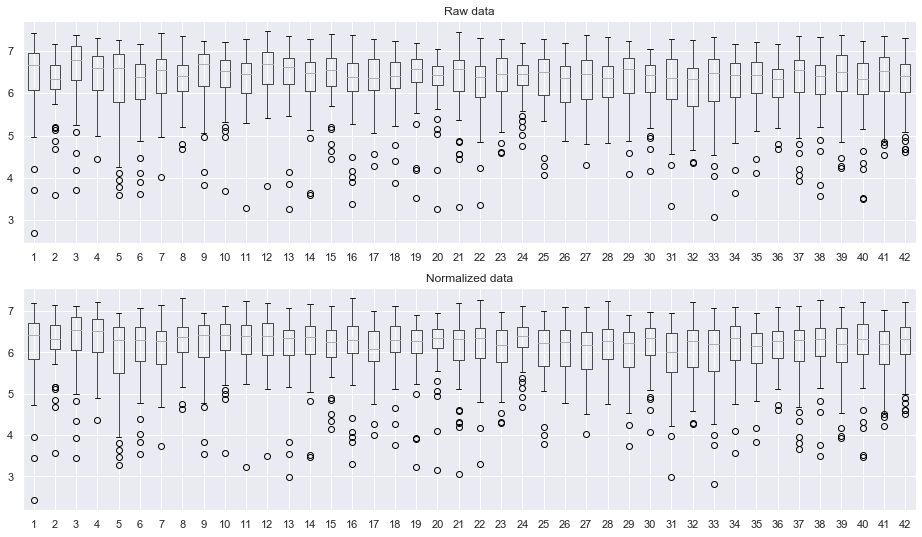

In [103]:
for strain_idx in range(len(targeted_perS_list)):
    
    # transform to log
    table_1 = targeted_perS_list[strain_idx].copy().applymap(lambda x: np.log10(x))
    table_2 = targeted_perS_norm_list[strain_idx].copy().applymap(lambda x: np.log10(x))

    plt.figure(figsize=(16,9))

    xticks_pos = np.arange(1,43,1)
    #xticks_labels = strain_list

    plt.subplot(211)
    table_1.boxplot()
    plt.xticks(ticks = xticks_pos, labels = xticks_pos)#, rotation = 70)
    plt.title('Raw data')
    
    plt.subplot(212)
    table_2.boxplot()
    plt.xticks(ticks = xticks_pos, labels = xticks_pos)#, rotation = 70)
    plt.title('Normalized data')
    
    plt.suptitle('Normalization of targeted data - ' + strain_list[strain_idx])

    #plt.show()

    plt.savefig('intermed_results/04_normalization/norm_targeted_overveiw/'+\
            today+'_'+str(strain_idx).zfill(2)+'_tar_norm_'+strain_list[strain_idx]+'.pdf',\
            bbox_inches='tight')
    
    plt.close('all')


### Normalization of untargeted data

In [32]:
# get normalization factor of control pools

# check missingness

is_missingness = []

for is_data in untar_IS_vals_perS:
    # get control pool identifiers
    col_names = is_data.columns
    col_names = [col for col in col_names if 'Pool9' in col]
    # select values and cound missing values
    control_pool_vals = is_data.loc[:,col_names]
    miss_vec = pd.Series(control_pool_vals.isnull().sum(axis=1))
    is_missingness.append(miss_vec)


is_miss_df = pd.DataFrame(is_missingness)

is_miss_df


IS_CAFFEINE  IS_IPRIFLAVONE  IS_MIFEPRISTONE  IS_SULFAMETHOXAZOLE  \
0             0               0                0                    0   
1             0               0                0                    0   
2             0               0                0                    0   
3             0               0                0                    0   
4             0               0                0                    0   
5             0               0                0                    0   
6             0               0                0                    0   
7             0               0                0                    0   
8             0               0                0                    0   
9             0               0                0                    0   
10            0               0                0                    0   
11            0               0                0                    0   
12            0               0                0                    0   
13            0               0                0                    0   
14            0               0                0                    0   
15            0               0                0                    0   
16            0               0                0                    0   
17            0               0                0                    0   
18            0               0                0                    0   
19            0               0                0                    0   
20            0               0                0                    0   
21            0               0                0                    0   
22            0               0                0                    0   
23            0               0                0                    0   
24            0               0                0                    0   
25            0               0                0                    0   
26            0               0                0                    0   
27            0               0                0                    0   
28            0               0                0                    0   
29            0               0                0                    0   
30            0               0                0                    0   
31            0               0                0                    0   
32            0               0                0                    0   
33            0               0                0                    0   
34            0               0                0                    0   
35            0               0                0                    0   
36            0               0                0                    0   
37            0               0                0                    0   
38            0               0                0                    0   
39            0               0                0                    0   
40            0               0                0                    0   
41            0               0                0                    0   
42            0               0                0                    0   
43            0               0                0                    0   
44            0               0                0                    0   
45            0               0                0                    0   
46            0               0                0                    0   
47            0               0                0                    0   
48            0               0                0                    0   
49            0               0                0                    0   
50            0               0                0                    0   
51            0               0                0                    0   
52            0               0                0                    0   
53            0               0                0              

In [17]:
# add normalization factor of control pools to factors based on targeted data

alpha_perS_record_plus_contr = []

untargeted_perS_norm_list = []

for s_idx, table in enumerate(untargeted_perS_list):
    
    table_vals = table.loc[:,table.columns.str.endswith('(raw)')].copy()

    IS_rows = untar_IS_vals_perS[s_idx]

    col_names = IS_rows.columns
    col_names = [col for col in col_names if 'Pool9' in col]

    alpha_record = pd.DataFrame(columns = col_names, index = ['alpha'])

    for col in col_names:
        is_vals = IS_rows.loc[:, col] # here it becomes a pd series, so keys() is used below

        # divide by median and sort
        is_vals_scaled = pd.Series([is_vals[is_name]/IS_med_untar_dict[is_name] for \
                                    is_name in is_vals.keys()],\
                                    index = IS_use_list).sort_values()

        # get normalisation factor (mean of more stable IS)
        alpha = np.nanmean(is_vals_scaled.take([1,2,3]))

        alpha_record.loc['alpha', col] = alpha

    alpha_perS_record_combined = pd.concat([alpha_perS_record[s_idx], alpha_record], axis = 1)
    
    alpha_perS_record_plus_contr.append(alpha_perS_record_combined)
    
    # devide each column by normalization factor
    for i, col in enumerate(table_vals.columns):
        table_vals.loc[:,col] = table_vals.loc[:,col].copy() / np.float(alpha_perS_record_combined.iloc[:,i])
    
    # add info columns from original tables
    norm_table = pd.concat([table_vals, table.iloc[:,-4:]], axis = 1)
    
    untargeted_perS_norm_list.append(norm_table)



In [94]:
for i, table in enumerate(untargeted_perS_norm_list):
    s_name = table.columns[0].split('-')[3]
    table.to_csv('intermed_results/04_normalization/data/untargeted/'+\
                     str(i+1).zfill(2)+'_untar_norm_'+s_name+'.txt', sep = ';')
    

In [20]:
alpha_perS_record_plus_contr[1]

MZ002H-Pool01-P001B2-S006-T00-Area MZ002H-Pool01-P001B2-S006-T12-Area  \
alpha                           0.806419                           0.737677   

      MZ002H-Pool02-P001B2-S006-T00-Area MZ002H-Pool02-P001B2-S006-T12-Area  \
alpha                            0.83548                           0.720794   

      MZ002H-Pool03-P001B2-S006-T00-Area MZ002H-Pool03-P001B2-S006-T12-Area  \
alpha                            0.82402                           0.814215   

      MZ002H-Pool04-P001B2-S006-T00-Area MZ002H-Pool04-P001B2-S006-T12-Area  \
alpha                           0.776156                            0.82769   

      MZ002H-Pool05-P001B2-S006-T00-Area MZ002H-Pool05-P001B2-S006-T12-Area  \
alpha                           0.829558                           0.813786   

      MZ002H-Pool06-P001B2-S006-T12-Area MZ002H-Pool06-P001B2-S006-T00-Area  \
alpha                           0.817205                           0.809597   

      MZ002H-Pool07-P001B2-S006-T00-Area MZ002H-Pool07-P001B2-S006-T12-Area  \
alpha                           0.801214                           0.798623   

      MZ002H-Pool08-P001B2-S006-T00-Area MZ002H-Pool08-P001B2-S006-T12-Area  \
alpha                           0.797449                           0.840986   

      MZ002H-Pool09-P001B2-S006-T00-Area MZ002H-Pool09-P001B2-S006-T12-Area  \
alpha                            0.80421                           0.788882   

      MZ002H-Pool10-P001B2-S006-T00-Area MZ002H-Pool10-P001B2-S006-T12-Area  \
alpha                           0.807013                           0.821755   

      MZ002H-Pool11-P001B2-S006-T00-Area MZ002H-Pool11-P001B2-S006-T12-Area  \
alpha                           0.721387                           0.775492   

      MZ002H-Pool12-P001B2-S006-T00-Area MZ002H-Pool12-P001B2-S006-T12-Area  \
alpha                           0.778562                           0.843291   

      MZ002H-Pool13-P001B2-S006-T00-Area MZ002H-Pool13-P001B2-S006-T12-Area  \
alpha                           0.782281                           0.834999   

      MZ002H-Pool14-P001B2-S006-T00-Area MZ002H-Pool14-P001B2-S006-T12-Area  \
alpha                           0.849096                           0.841047   

      MZ002H-Pool15-P001B2-S006-T00-Area MZ002H-Pool15-P001B2-S006-T12-Area  \
alpha                           0.831359                            0.85222   

      MZ002H-Pool16-P001B2-S006-T00-Area MZ002H-Pool16-P001B2-S006-T12-Area  \
alpha                           0.865006                           0.946554   

      MZ002H-Pool17-P001B2-S006-T00-Area MZ002H-Pool17-P001B2-S006-T12-Area  \
alpha                           0.745934                           0.800352   

      MZ002H-Pool18-P001B2-S006-T00-Area MZ002H-Pool18-P001B2-S006-T12-Area  \
alpha                           0.832514                           0.850132   

      MZ002H-Pool19-P001B2-S006-T00-Area MZ002H-Pool19-P001B2-S006-T12-Area  \
alpha                           0.751599                           0.733374   

      MZ002H-Pool20-P001B2-S006-T00-Area MZ002H-Pool20-P001B2-S006-T12-Area  \
alpha                           0.813066                           0.835901   

      MZ002H-Pool21-P001B2-S006-T00-Area MZ002H-Pool21-P001B2-S006-T12-Area  \
alpha                           0.838288                           0.839329   

      MZ002H-Pool97-P001B2-S006-T00(raw) MZ002H-Pool97-P001B2-S006-T12(raw)  \
alpha                           0.816096                           0.840015   

      MZ002H-Pool98-P001B2-S006-T00(raw) MZ002H-Pool98-P001B2-S006-T12(raw)  \
alpha                           0.848865                           0.867308   

      MZ002H-Pool99-P001B2-S006-T00(raw) MZ002H-Pool99-P001B2-S006-T12(raw)  
alpha                           0.907363                           0.905064

In [98]:
untargeted_perS_list[0]

MZ002H-Pool01-P001B1-S005-T00(raw)  \
Compound                                                  
99.105@3.9642856                                    NaN   
99.9371@4.182                                       NaN   
99.9498@0.21133333                                  NaN   
99.9811@0.46170002                              27748.0   
99.9832@0.52983874                             178938.0   
...                                                 ...   
994.0531@0.43111765                             28211.0   
994.4485@3.3237498                                  NaN   
994.8442@2.53817                                30990.0   
995.3458@2.5388691                              22724.0   
996.505@2.165846                                    NaN   

                     MZ002H-Pool01-P001B1-S005-T12(raw)  \
Compound                                                  
99.105@3.9642856                                    NaN   
99.9371@4.182                                       NaN   
99.9498@0.21133333                                  NaN   
99.9811@0.46170002                                  NaN   
99.9832@0.52983874                             158509.0   
...                                                 ...   
994.0531@0.43111765                                 NaN   
994.4485@3.3237498                                  NaN   
994.8442@2.53817                                63711.0   
995.3458@2.5388691                              37860.0   
996.505@2.165846                                    NaN   

                     MZ002H-Pool02-P001B1-S005-T00(raw)  \
Compound                                                  
99.105@3.9642856                                    NaN   
99.9371@4.182                                       NaN   
99.9498@0.21133333                                  NaN   
99.9811@0.46170002                              17177.0   
99.9832@0.52983874                             119022.0   
...                                                 ...   
994.0531@0.43111765                             27155.0   
994.4485@3.3237498                                  NaN   
994.8442@2.53817                                34448.0   
995.3458@2.5388691                              25977.0   
996.505@2.165846                                    NaN   

                     MZ002H-Pool02-P001B1-S005-T12(raw)  \
Compound                                                  
99.105@3.9642856                                    NaN   
99.9371@4.182                                       NaN   
99.9498@0.21133333                                  NaN   
99.9811@0.46170002                                  NaN   
99.9832@0.52983874                             143154.0   
...                                                 ...   
994.0531@0.43111765                             12988.0   
994.4485@3.3237498                                  NaN   
994.8442@2.53817                                55865.0   
995.3458@2.5388691                              37272.0   
996.505@2.165846                                    NaN   

                     MZ002H-Pool03-P001B1-S005-T00(raw)  \
Compound                                                  
99.105@3.9642856                                26904.0   
99.9371@4.182                                       NaN   
99.9498@0.21133333                                  NaN   
99.9811@0.46170002                                  NaN   
99.9832@0.52983874                             101150.0   
...                                                 ...   
994.0531@0.43111765                             16558.0   
994.4485@3.3237498                                  NaN   
994.8442@2.53817                                35676.0   
995.3458@2.5388691                              26459.0   
996.505@2.165846                                    NaN   

                     MZ002H-Pool03-P001B1-S005-T12(raw)  \
Compound                                                  
99.105@3.9642856                                23308.0   
99.9

In [47]:
strain_idx = 0

# transform to log
table_1 = untargeted_perS_list[strain_idx].iloc[:,:-4].copy().applymap(lambda x: np.log10(x))
table_2 = untargeted_perS_norm_list[strain_idx].iloc[:,:-4].copy().applymap(lambda x: np.log10(x))

IS_row = np.log10(untar_IS_vals_perS[strain_idx].iloc[0,:-4].values.tolist())
IS_row_norm = np.log10(np.divide(untar_IS_vals_perS[strain_idx].iloc[0,:-4], alpha_perS_record_plus_contr[strain_idx].iloc[:,:]).values.tolist()[0])

In [48]:
IS_row_norm

array([5.99181192, 5.96428931, 5.99734283, 6.00362578, 6.00202363,
       5.99655736, 6.0164849 , 6.04888661, 5.97362567, 5.99150622,
       5.9904286 , 6.01626068, 6.01016699, 6.00809378, 6.03851947,
       6.03661655, 5.96502705, 5.96615246, 6.00292663, 6.01913253,
       5.99625424, 5.97731268, 6.05672181, 6.02065025, 5.99914555,
       5.95637458, 6.03494291, 6.01517858, 5.97762648, 5.978477  ,
       5.98955907, 5.99176815, 6.00514848, 5.98305312, 6.01698375,
       6.20018932, 6.02063177, 5.99596949, 5.99395625, 5.97974419,
       5.97573684, 5.92348567, 6.020136  , 5.96927212, 6.0159464 ,
       5.99250265, 6.03797213, 5.99120408])

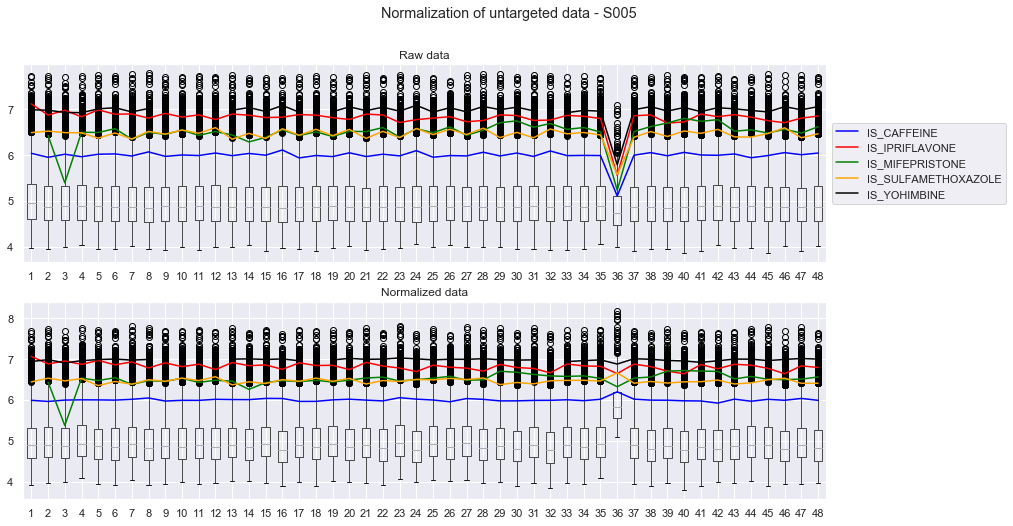

In [59]:
strain_idx = 0

# transform to log
table_1 = untargeted_perS_list[strain_idx].iloc[:,:-4].copy().applymap(lambda x: np.log10(x))
table_2 = untargeted_perS_norm_list[strain_idx].iloc[:,:-4].copy().applymap(lambda x: np.log10(x))

col_vec = ['blue','red','green','orange','black']

plt.figure(figsize=(18,8))

xticks_pos = np.arange(1,49,1)
#xticks_labels = strain_list

ax1 = plt.subplot(211)
table_1.boxplot(ax = ax1)

for IS_idx in range(5):
    IS_row =  np.log10(untar_IS_vals_perS[strain_idx].iloc[IS_idx,:-4].values.tolist())
    ax1.plot(xticks_pos, IS_row, label = untar_IS_vals_perS[strain_idx].index[IS_idx], c = col_vec[IS_idx])

ax1.set_xticks(ticks = xticks_pos)#, rotation = 70)
ax1.set_xticklabels(xticks_pos)
ax1.set_title('Raw data')

box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))



ax2 = plt.subplot(212)
table_2.boxplot()

for IS_idx in range(5):
    IS_row_norm =  np.log10(np.divide(untar_IS_vals_perS[strain_idx].iloc[IS_idx,:-4], alpha_perS_record_plus_contr[strain_idx].iloc[:,:]).values.tolist()[0])
    ax2.plot(xticks_pos, IS_row_norm, label = untar_IS_vals_perS[strain_idx].index[IS_idx], c = col_vec[IS_idx])

ax2.set_xticks(ticks = xticks_pos)#, rotation = 70)
ax2.set_xticklabels(xticks_pos)
ax2.set_title('Normalized data')

box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
#ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle('Normalization of untargeted data - ' + strain_list[strain_idx])

plt.show()

plt.savefig('intermed_results/04_normalization/norm_untargeted_overview/'+\
        today+'_'+str(strain_idx).zfill(2)+'_untar_norm_'+strain_list[strain_idx]+'.pdf',\
        bbox_inches='tight')

plt.close('all')


In [61]:
for strain_idx in range(len(untargeted_perS_list)):
    
    # transform to log
    table_1 = untargeted_perS_list[strain_idx].iloc[:,:-4].copy().applymap(lambda x: np.log10(x))
    table_2 = untargeted_perS_norm_list[strain_idx].iloc[:,:-4].copy().applymap(lambda x: np.log10(x))

    col_vec = ['blue','red','green','orange','black']

    plt.figure(figsize=(18,8))

    xticks_pos = np.arange(1,49,1)
    #xticks_labels = strain_list

    ax1 = plt.subplot(211)
    table_1.boxplot(ax = ax1)

    for IS_idx in range(5):
        IS_row =  np.log10(untar_IS_vals_perS[strain_idx].iloc[IS_idx,:-4].values.tolist())
        ax1.plot(xticks_pos, IS_row, label = untar_IS_vals_perS[strain_idx].index[IS_idx], c = col_vec[IS_idx])

    ax1.set_xticks(ticks = xticks_pos)#, rotation = 70)
    ax1.set_xticklabels(xticks_pos)
    ax1.set_title('Raw data')

    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))



    ax2 = plt.subplot(212)
    table_2.boxplot()

    for IS_idx in range(5):
        IS_row_norm =  np.log10(np.divide(untar_IS_vals_perS[strain_idx].iloc[IS_idx,:-4], alpha_perS_record_plus_contr[strain_idx].iloc[:,:]).values.tolist()[0])
        ax2.plot(xticks_pos, IS_row_norm, label = untar_IS_vals_perS[strain_idx].index[IS_idx], c = col_vec[IS_idx])

    ax2.set_xticks(ticks = xticks_pos)#, rotation = 70)
    ax2.set_xticklabels(xticks_pos)
    ax2.set_title('Normalized data')

    box = ax2.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    #ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.suptitle('Normalization of untargeted data - ' + strain_list[strain_idx])

    #plt.show()

    plt.savefig('intermed_results/04_normalization/norm_untargeted_overview/'+\
            today+'_'+str(strain_idx).zfill(2)+'_untar_norm_incl_IS_'+strain_list[strain_idx]+'.pdf',\
            bbox_inches='tight')

    plt.close('all')
